# Load Padoru Dataset from Hugging Face

Import the Padoru anime art dataset from Hugging Face Hub directly into Pixeltable tables.

**What's in this recipe:**
- Import Padoru dataset with anime character images from Hugging Face
- Complete dataset with all 382 images
- Automatic schema inference from dataset structure
- Work with anime art and character metadata in Pixeltable


## Problem

You want to work with anime character art in Pixeltable. The Padoru dataset contains 382 cute anime-style Christmas character images with metadata like character names, gender, and image sources.


## Solution

**What's in this recipe:**
- Import complete Padoru dataset (382 images) from Hugging Face
- Automatic schema handling for images and character metadata
- Work with anime art, character names, and attributes

You can use Pixeltable's native `create_table()` with a Hugging Face dataset URL to import data directly without manual downloading.


### Setup


In [1]:
!uv add pixeltable datasets

Resolved 261 packages in 4ms
Audited 164 packages in 15ms


In [2]:
import pixeltable as pxt
from datasets import load_dataset

### Load Padoru Dataset from Hugging Face

Load the [Padoru dataset](https://huggingface.co/datasets/not-lain/padoru) from Hugging Face. This dataset contains 382 anime character images in Padoru style with metadata.


In [3]:
# Load the complete Padoru dataset (all 382 images)
padoru_dataset = load_dataset('not-lain/padoru', split='train')

In [4]:
# Create directory for Padoru data
pxt.drop_dir('padoru_images', force=True)
pxt.create_dir('padoru_images')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata
Created directory 'padoru_images'.


### Create Pixeltable Table

Create a table with the image and character metadata from the dataset.


In [5]:
# Create table with schema for images and character metadata
t = pxt.create_table(
    'padoru_images.samples',
    schema={
        'image': pxt.Image,
        'name': pxt.String,
        'uid': pxt.String,
        'is_female': pxt.Bool,
        'is_humanoid': pxt.Bool,
        'image_size': pxt.Int
    },
    comment='Padoru anime character image dataset from Hugging Face'
)


Created table 'samples'.


In [6]:
# Prepare rows for insertion from Hugging Face dataset
rows = []
for idx, sample in enumerate(padoru_dataset):
    rows.append({
        'image': sample['Image'],
        'name': sample['Name'],
        'uid': sample['UID'],
        'is_female': sample['IsFemale'],
        'is_humanoid': sample['IsHumanoid'],
        'image_size': sample['ImageSize']
    })

t.insert(rows)

Inserting rows into `samples`: 382 rows [00:15, 24.94 rows/s]
Inserted 382 rows with 0 errors.


382 rows inserted, 1528 values computed.

image,name,is_female,is_humanoid
,AI-Chan,True,True
,Platelet,True,True
,Nezuko Kamado,True,True
,Azura,True,True
,Kaguya Shinomiya,True,True
,Mako Mankanshoku,True,True
,HH Chan,True,True
,Osu! Mascot,True,True
,Ruby Rose,True,True
,Komi Shouko,True,True

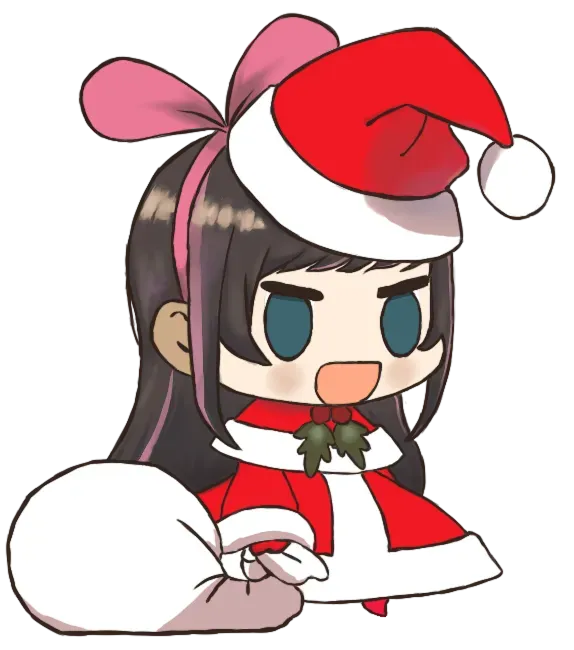
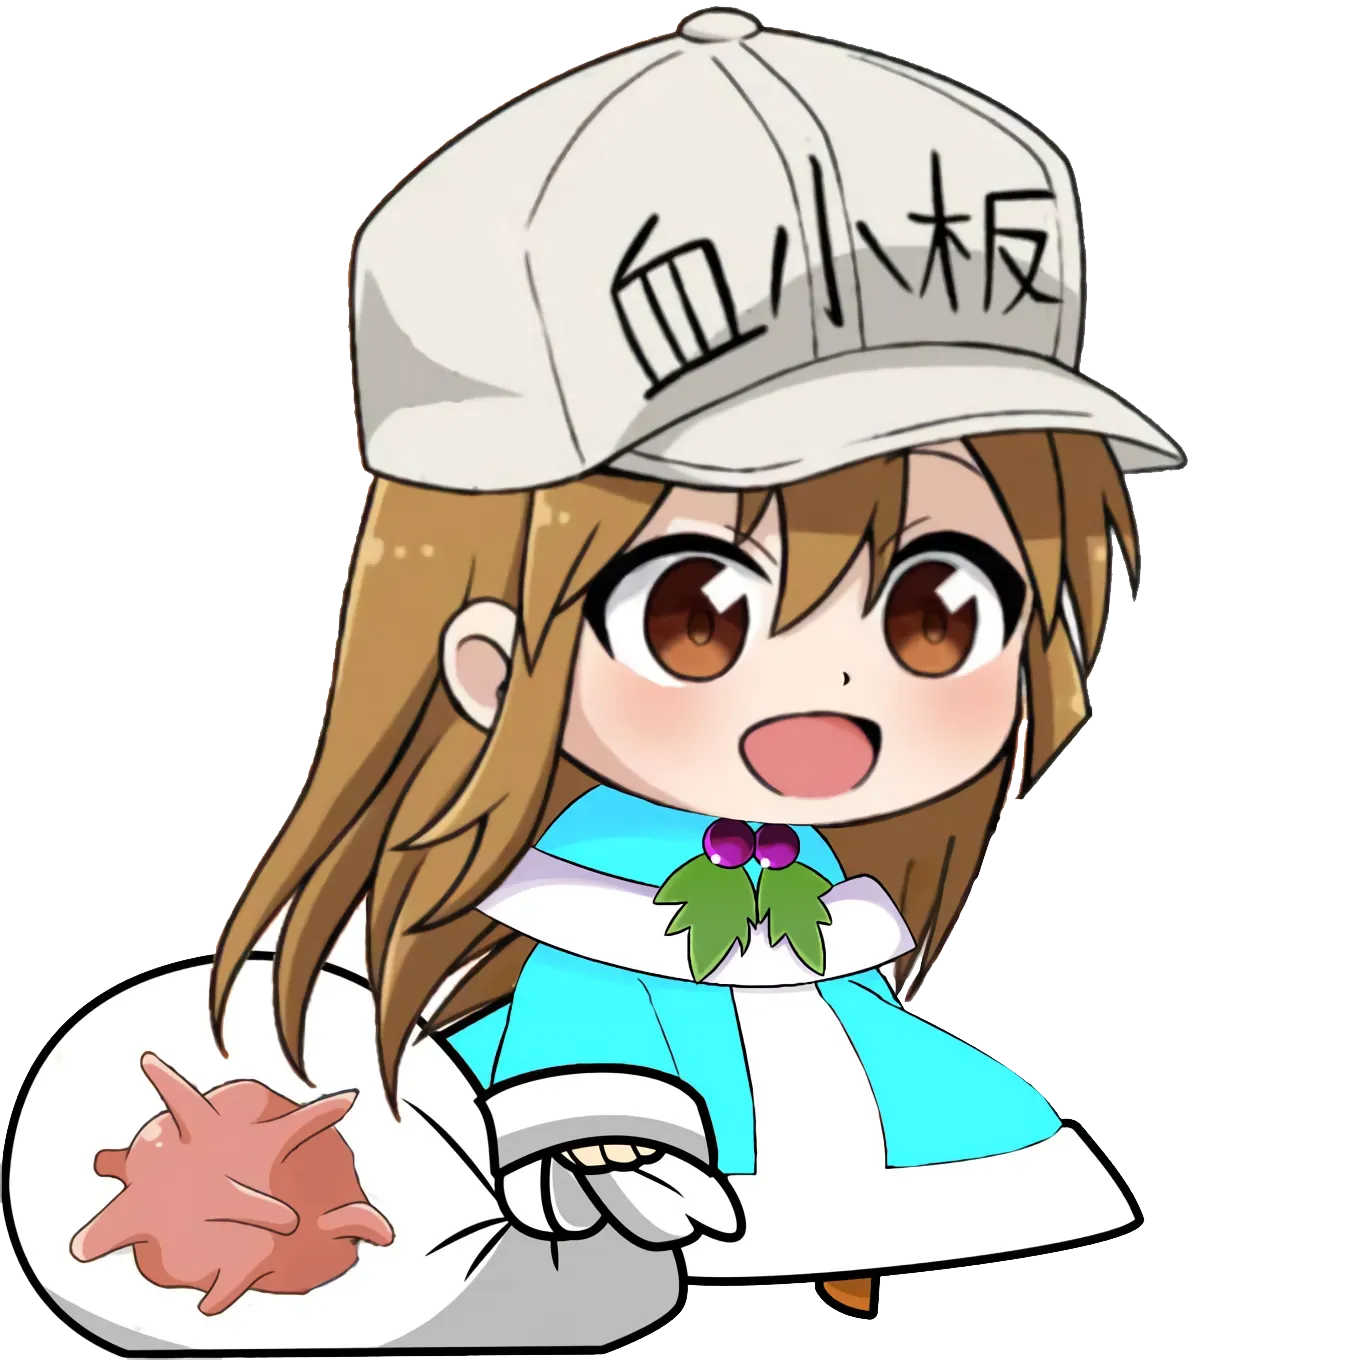
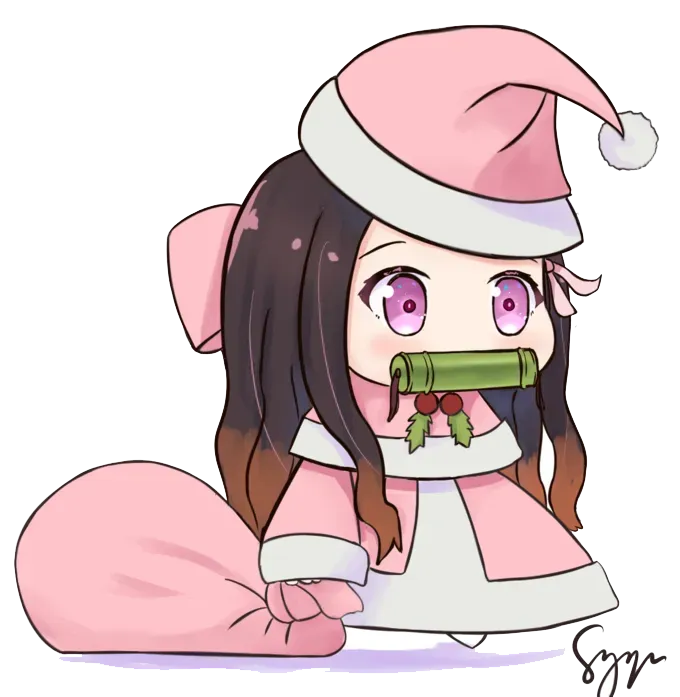
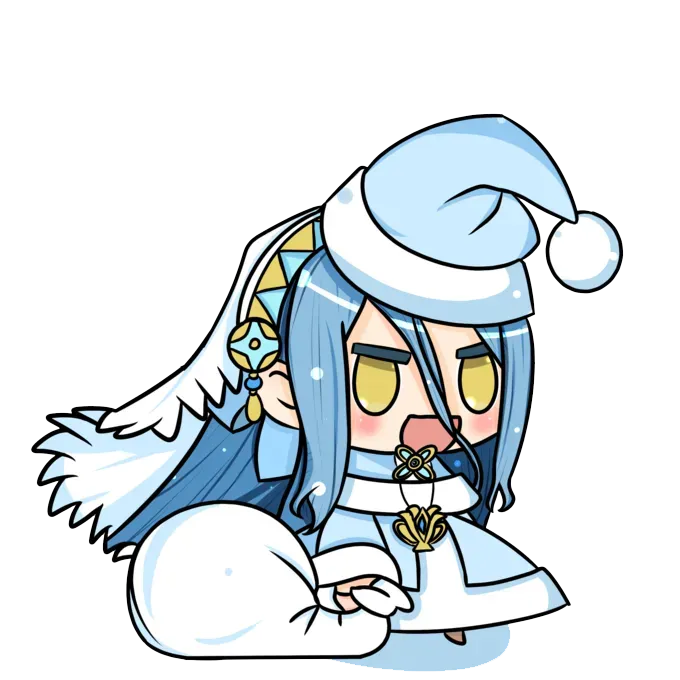
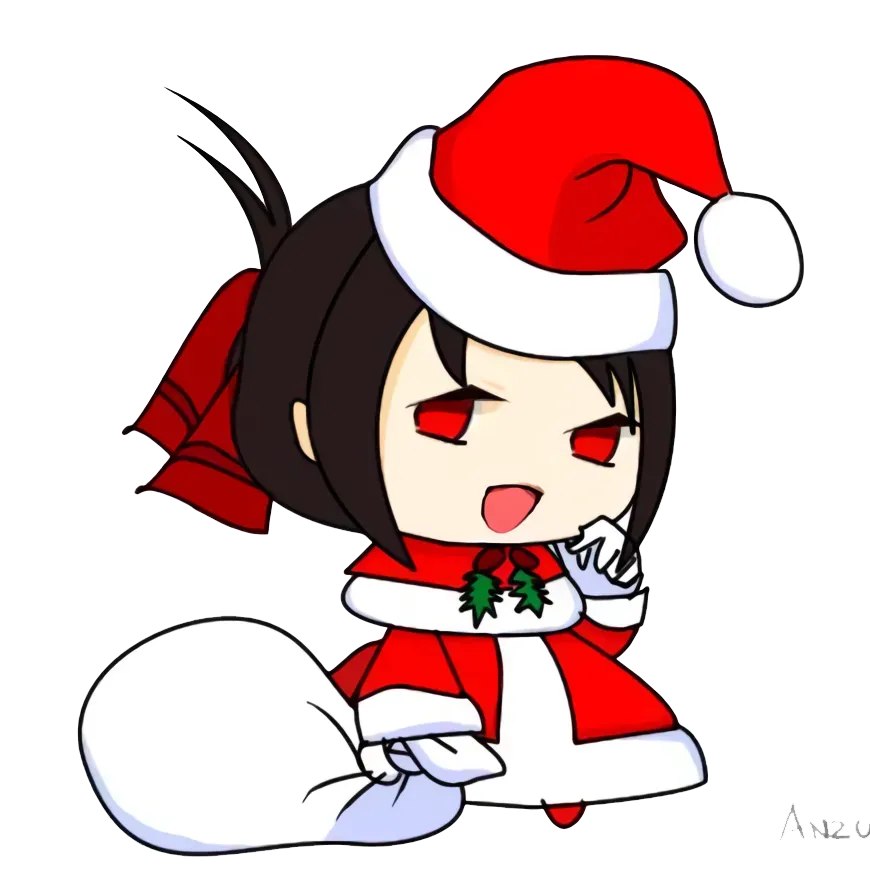
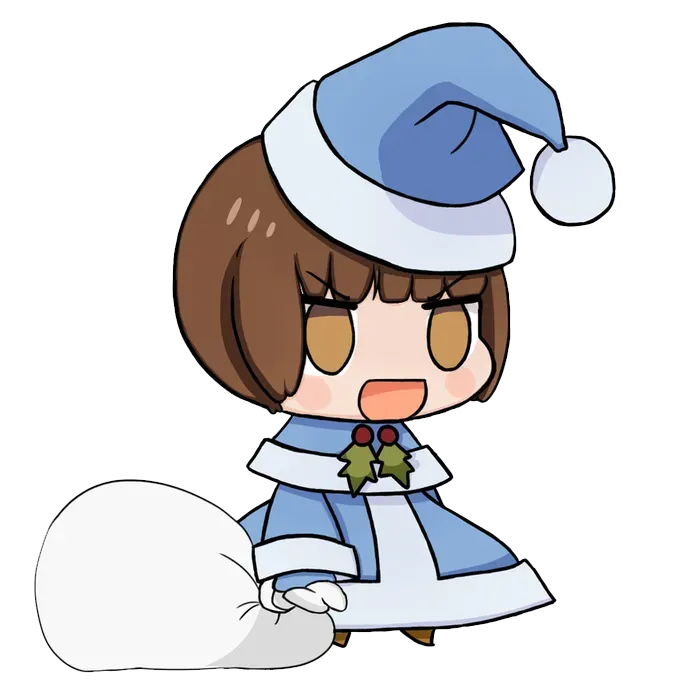
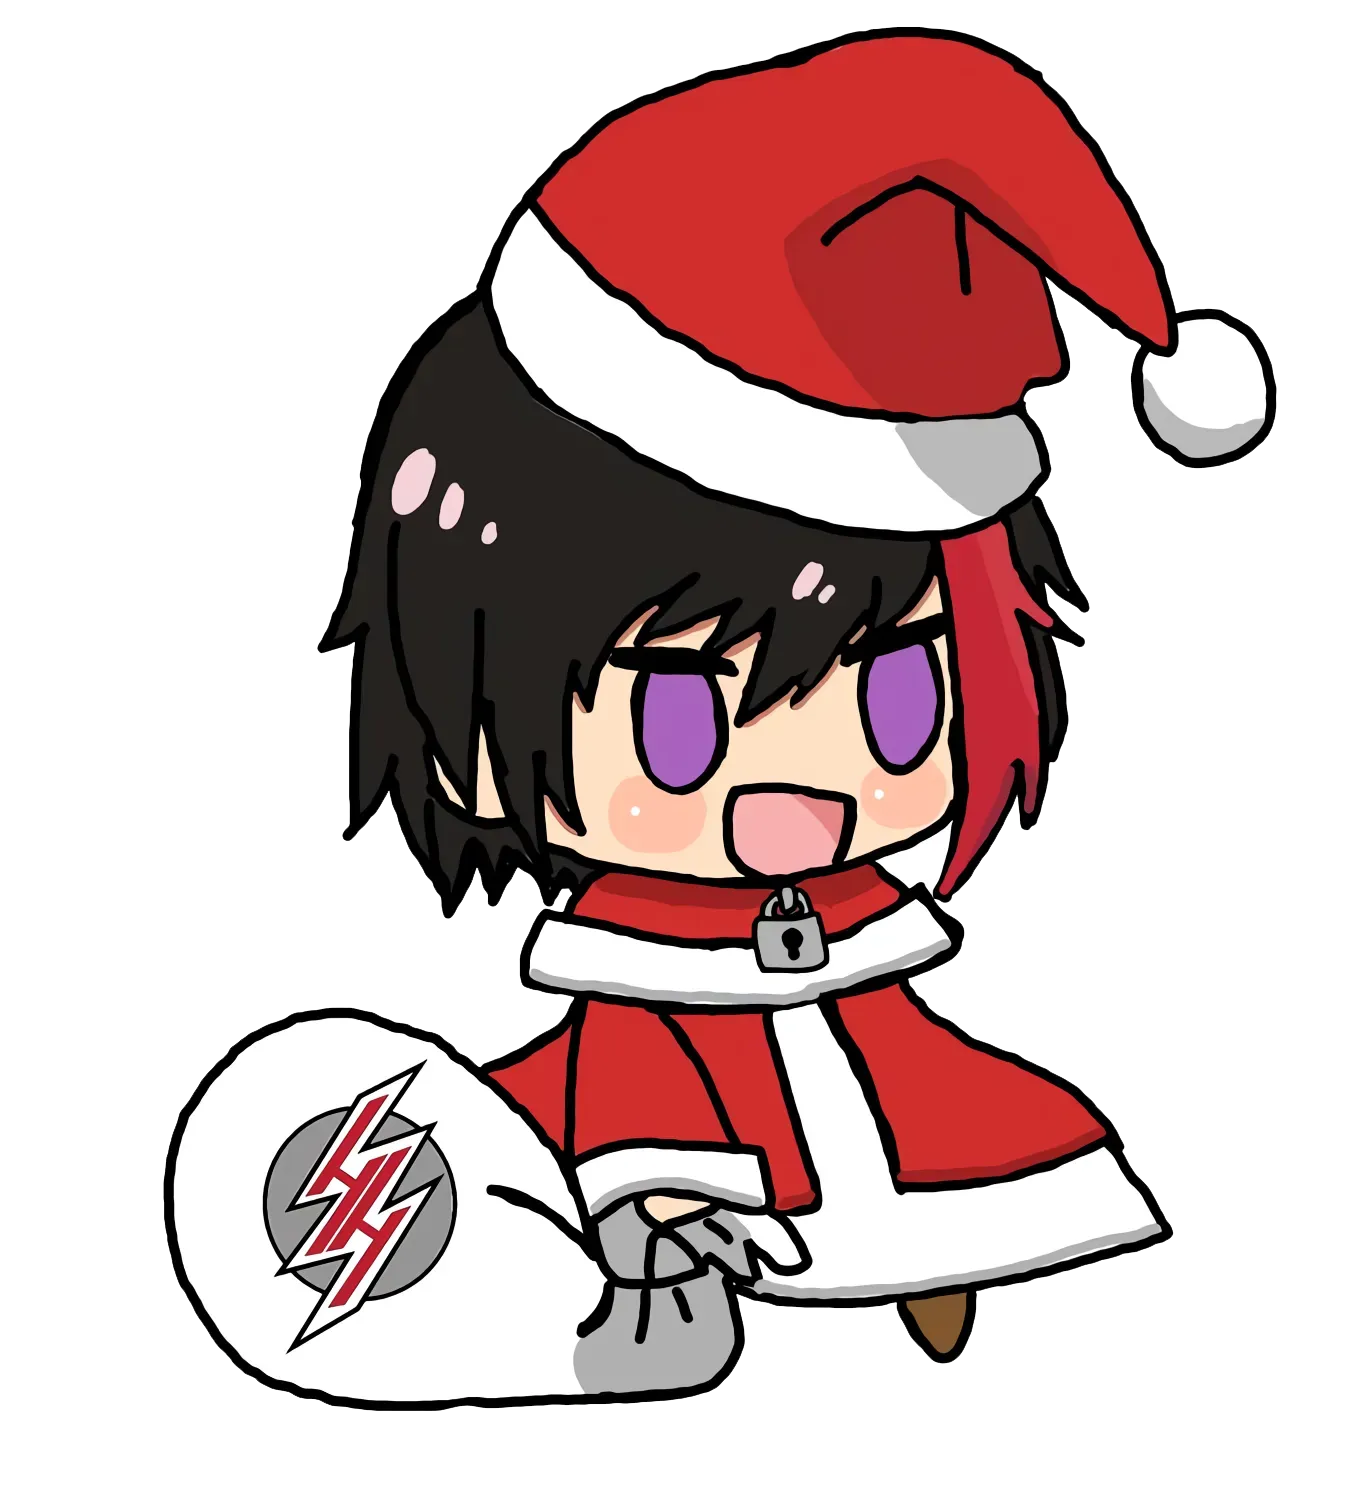
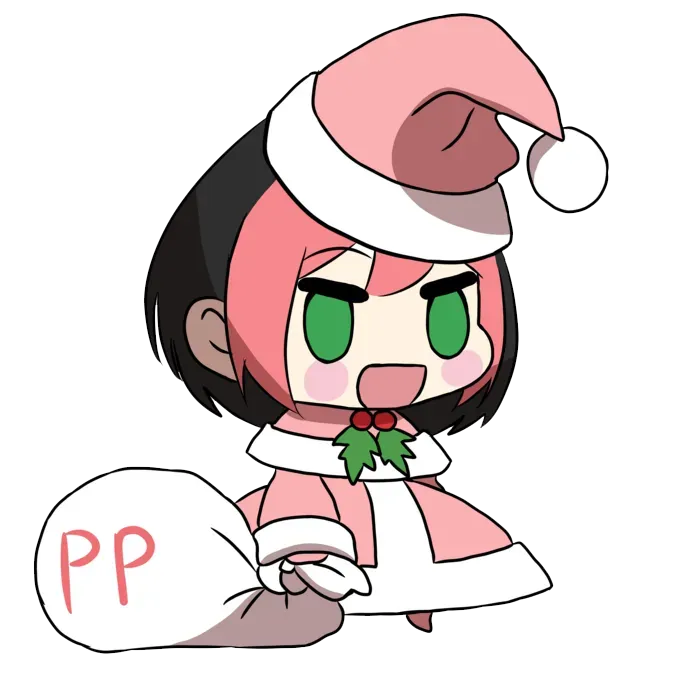
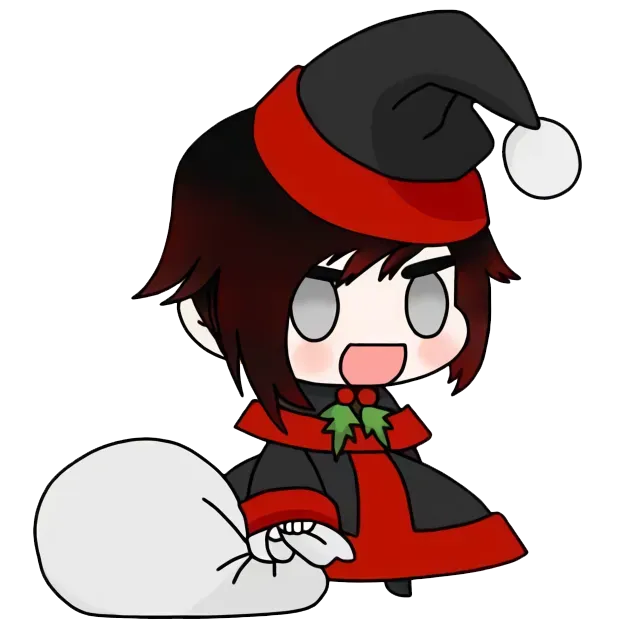
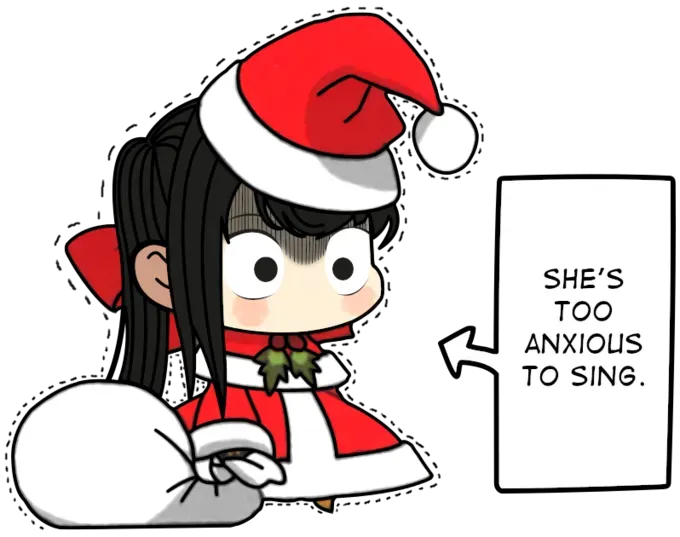

In [7]:
# View sample data
t.select(t.image, t.name, t.is_female, t.is_humanoid).head(10)

### Add AI Features

Add embeddings and AI-generated features to the images.


In [8]:
# Add CLIP embeddings for image similarity search
from pixeltable.functions.huggingface import clip

t.add_embedding_index(
    'image',
    embedding=clip.using(model_id='openai/clip-vit-base-patch32')
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


image,name,sim
,AI-Chan,1.
,Misaki Okusawa,0.963
,Rinko Shirokane,0.961
,Chizuru Ichinose,0.959
,Ran Mitake,0.952

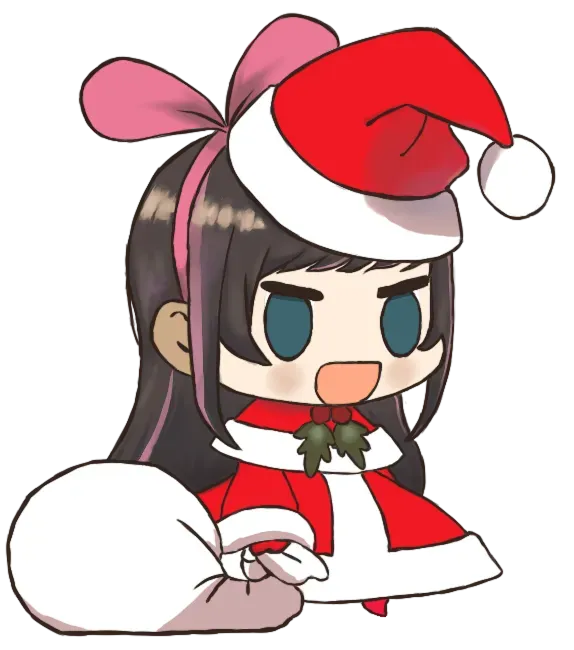
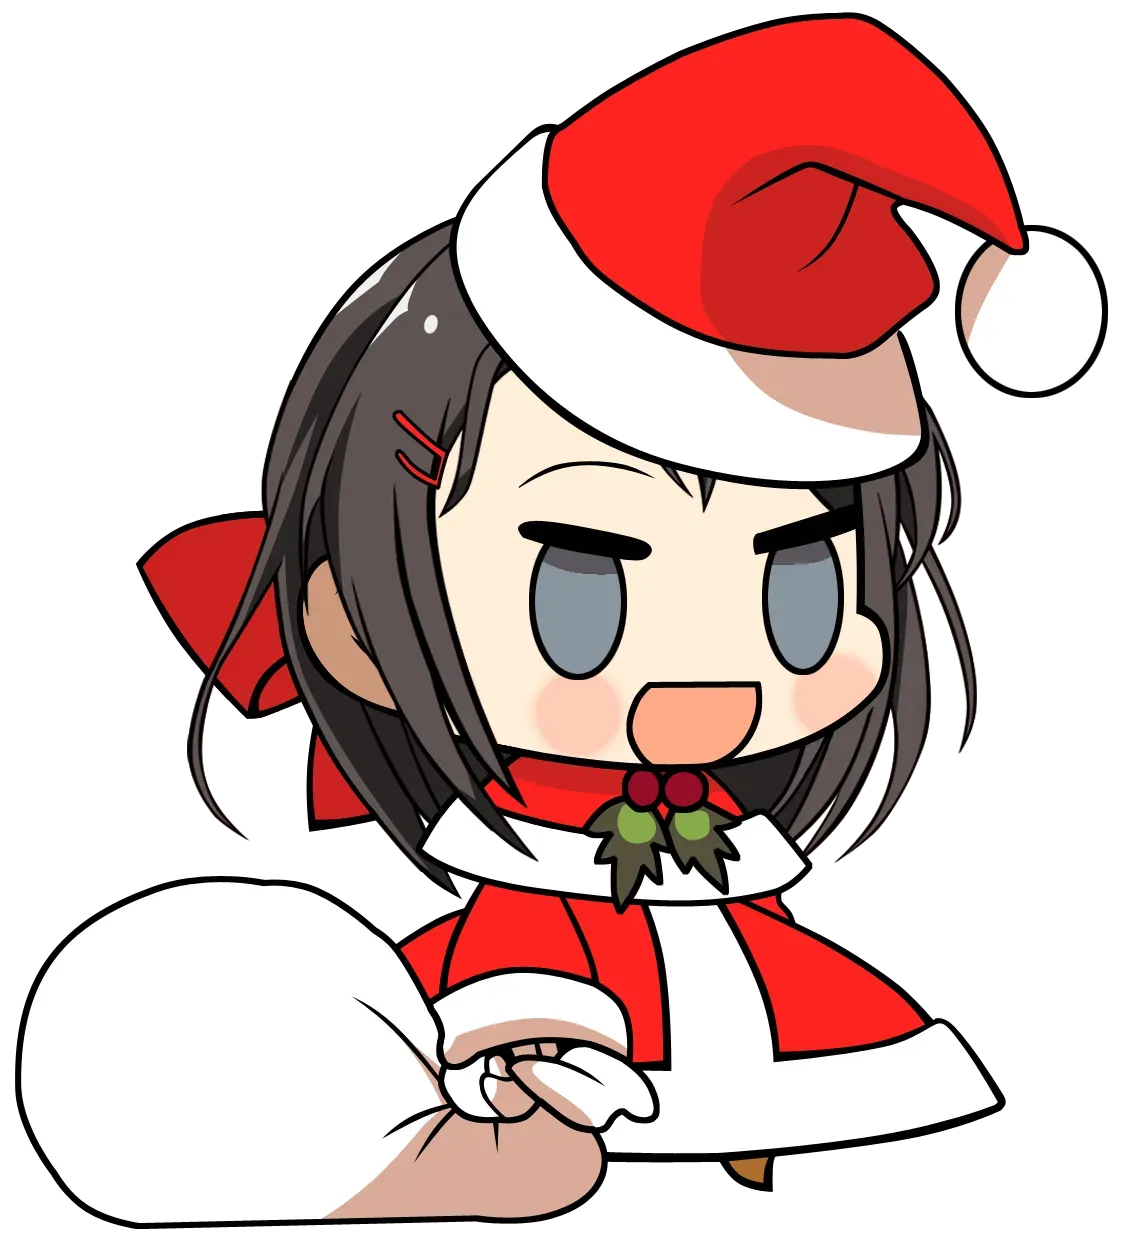
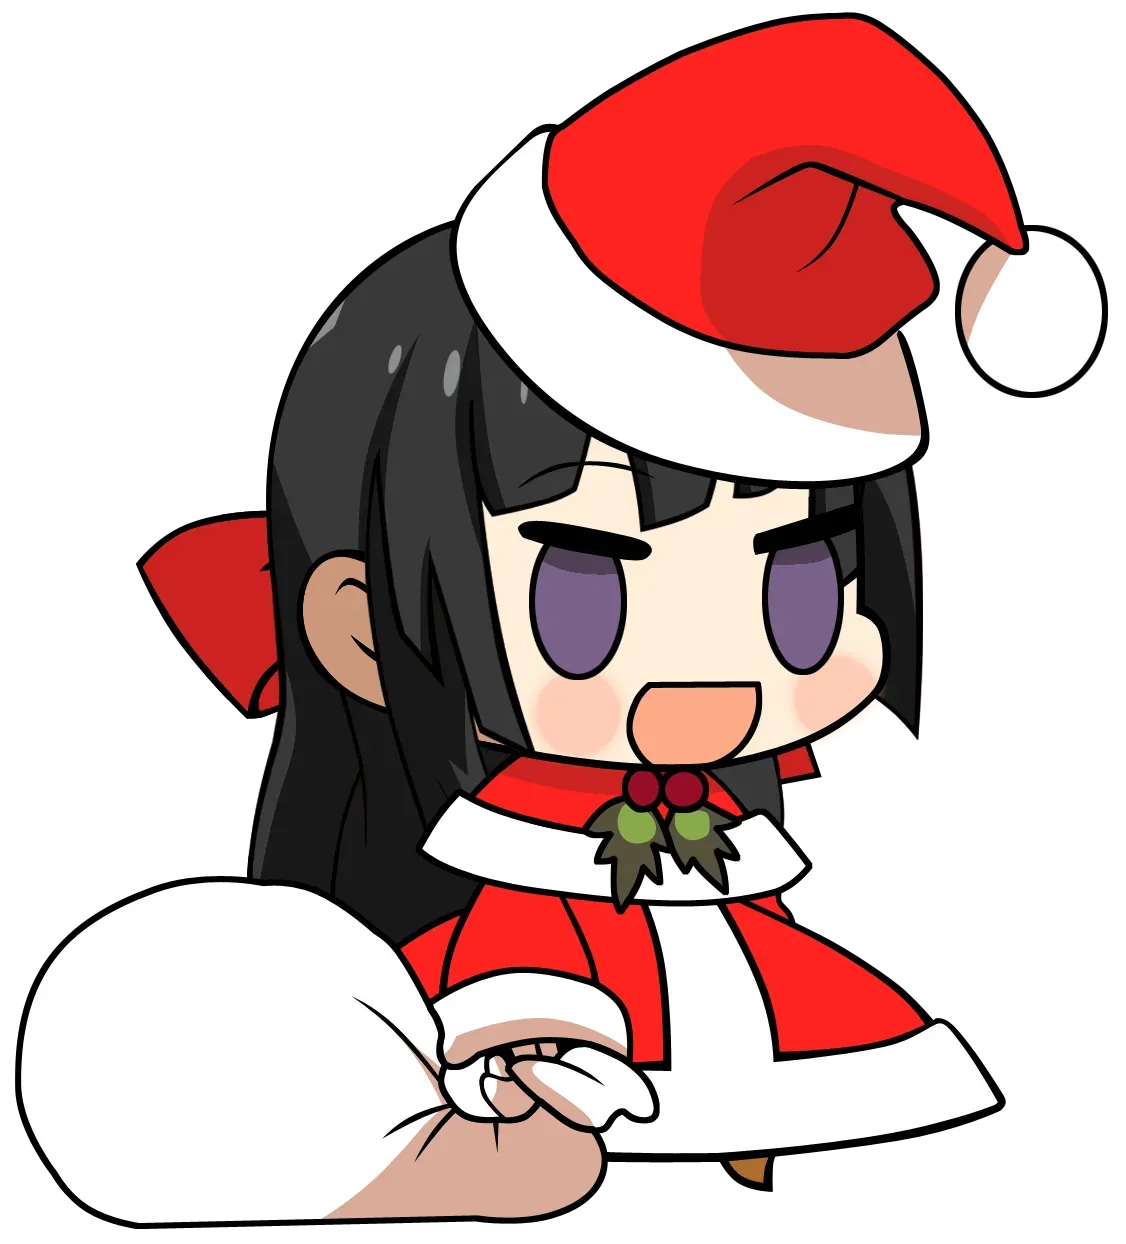
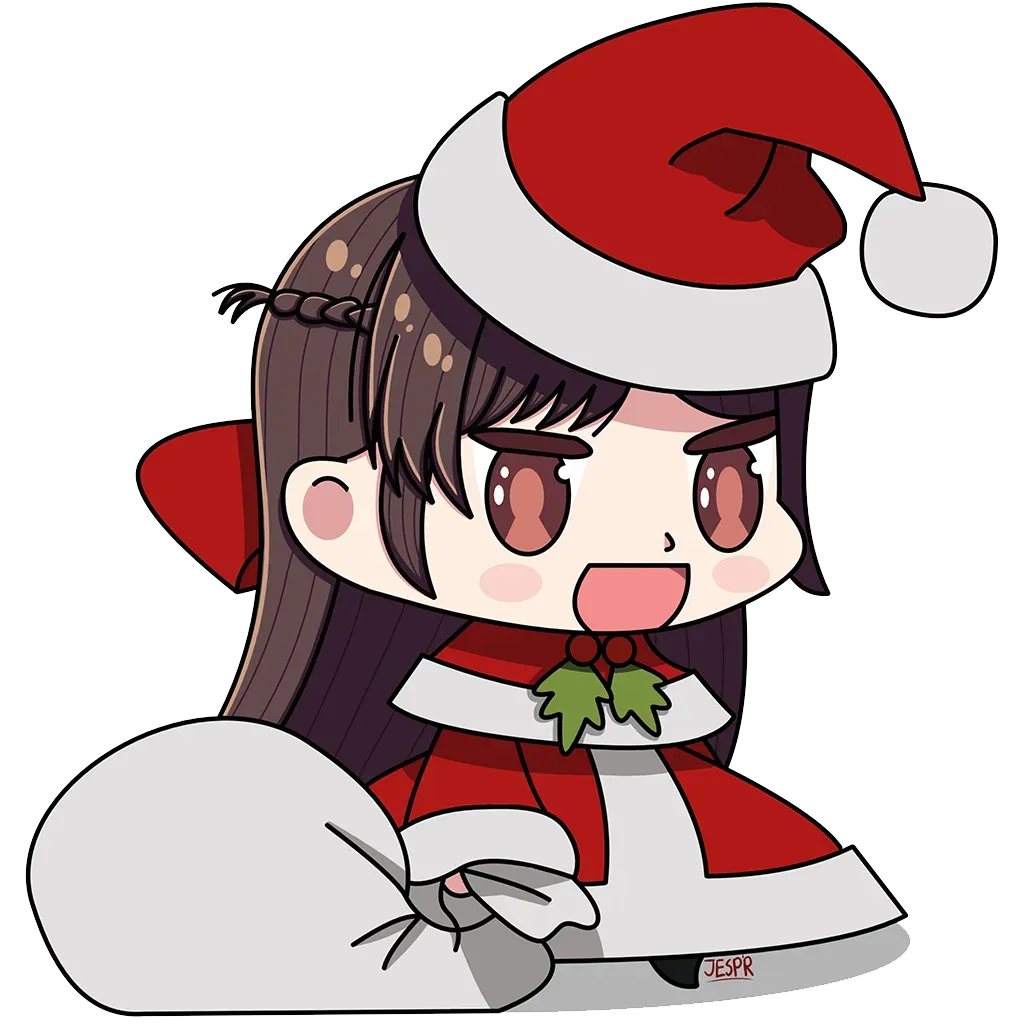
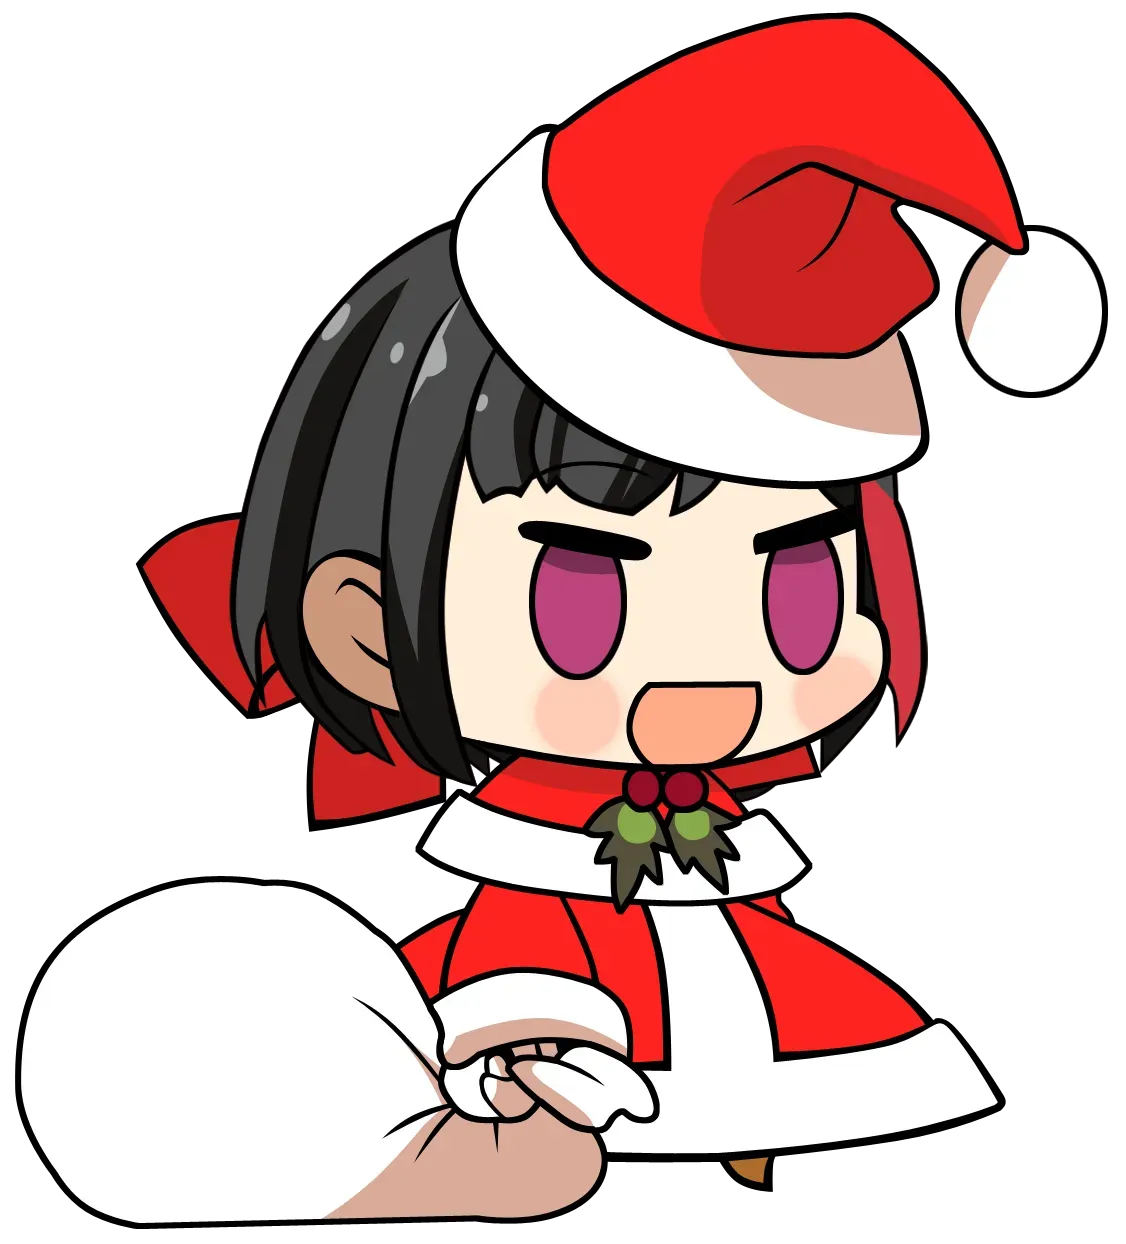

In [9]:
# Test similarity search - find similar images to the first one
sample_img = t.select(t.image).head(1)[0]['image']
sim = t.image.similarity(sample_img)

# View top 5 most similar images
t.order_by(sim, asc=False).limit(5).select(t.image, t.name, sim=sim).collect()

In [10]:
# Check total count
t.count()

382

### Publish to Pixeltable Cloud

Publish the table to make it available on Pixeltable Cloud.


In [11]:
# Publish the table to Pixeltable Cloud
pxt.publish(
    'padoru_images.samples',
    'pxt://pixeltable:hugging-face/padoru_anime_art',
    access='public'
)

Creating a replica of 'padoru_images.samples' at: pxt://pixeltable:hugging-face/padoru_anime_art
Uploading: 100%|███████████████████████████████████████████████| 25.5M/25.5M [00:01<00:00, 14.1MB/s]
Finalizing replica ...
The published table is now available at: pxt://pixeltable:hugging-face/padoru_anime_art


## See also

- [Padoru Dataset on Hugging Face](https://huggingface.co/datasets/not-lain/padoru)
- [Working with Embedding and Vector Indexes](https://docs.pixeltable.com/tutorials/embedding-indexes)
- [Hugging Face Integration](https://docs.pixeltable.com/api/functions/huggingface)
